In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys  

sys.path.insert(0, '../models')
from singlelocusmodelextended import SingleLocusModelExt
modelext = SingleLocusModelExt(k=1)

panel_label_kw = dict(size=22)#, weight='bold')
star_kw = dict(marker='*', c='w', s=60)
blue,yellow,green,red,pink,brown,pink2,grey,yellow2,blue2 = sns.color_palette("colorblind", 10)
sns.color_palette("colorblind", 10)
genotype_colors = [yellow,blue,grey,pink,green,red]
genotype_labels = ['$2n$','$2n+1$','$2n+1^*$',r'$2n^*_A$',r'$2n^*_M$',r'$2n^*_A+2n^*_M$']

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# MAP parameters

In [2]:
μ, δ, w1, w2, w3 = 2.942e-6, 1.722e-3, 1.022, 1.025, 1.028
N = int(6.425e6)

# Posterior $F_A$

In [3]:
post_sam = np.load('../../results/posterior_predictions/posterior_samples.npz', allow_pickle=True)['arr_0']
F_A = np.load('../../results/posterior_predictions/F_A-data.npz', allow_pickle=True)['arr_0']

In [4]:
mean_FA = np.mean(F_A)
perc_FA = np.percentile(F_A,(2.5, 97.5))
mean_FA, perc_FA

(0.16729464236904282, array([0.01540451, 0.36984928]))

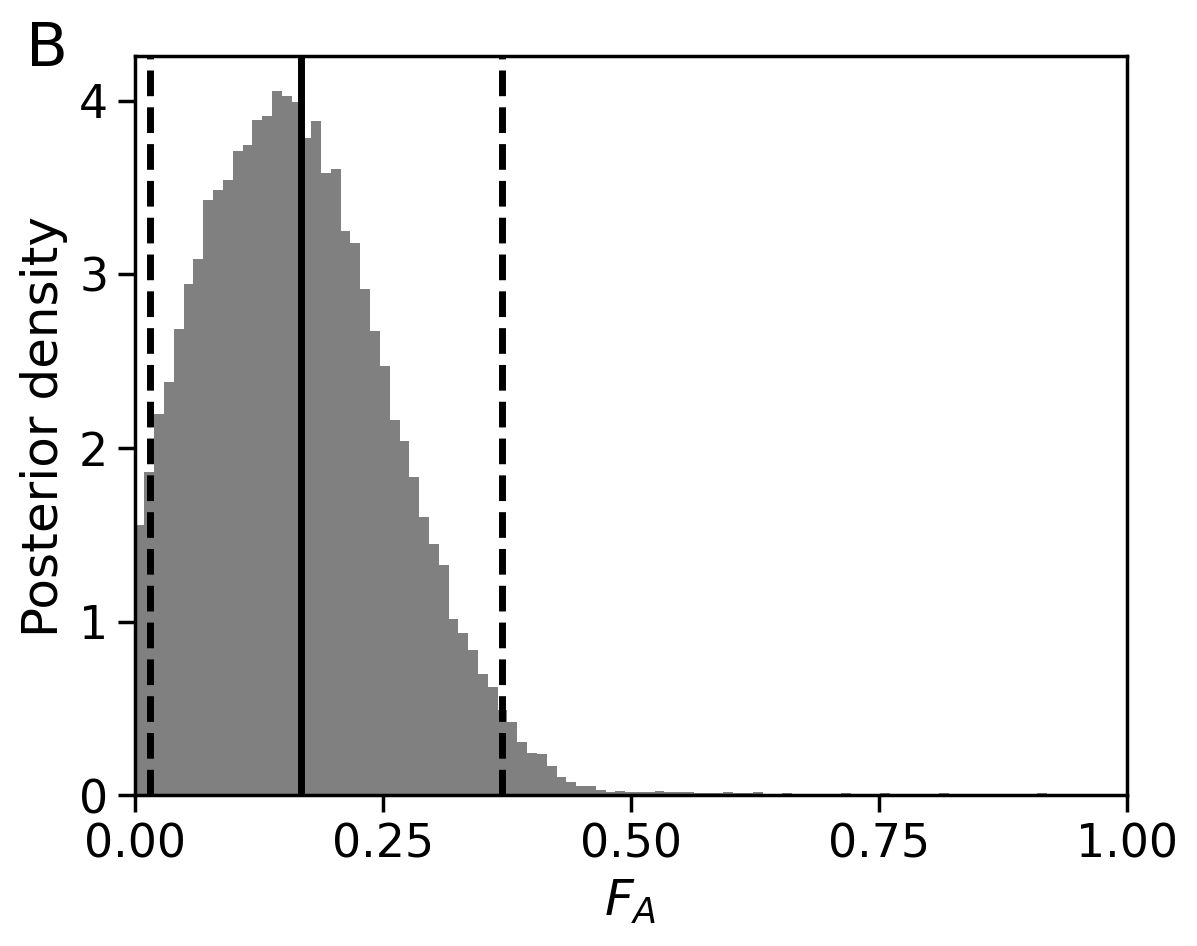

In [5]:
fig, ax = plt.subplots()
ax.hist(F_A, 100, density=True,color='grey')
ax.axvline(x=mean_FA,color='k')
ax.axvline(x=perc_FA[0],color='k',ls='--')
ax.axvline(x=perc_FA[1],color='k',ls='--')
ax.set_xlim([0,1])
panel_label = ax.text(-.11, 4.2, 'B',  **panel_label_kw)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
xlabel = ax.set_xlabel("$F_A$")
ax.set_ylabel('Posterior density')

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
# fig.savefig('../../figures/F_A_posterior.pdf', **bbox);

In [6]:
aneu_dom = F_A>.5
sum(aneu_dom), sum(aneu_dom)/len(F_A), len(F_A) #absolute number of cases where F_A is greater than 0.5, its fraction of the whole

(489, 0.00489, 100000)

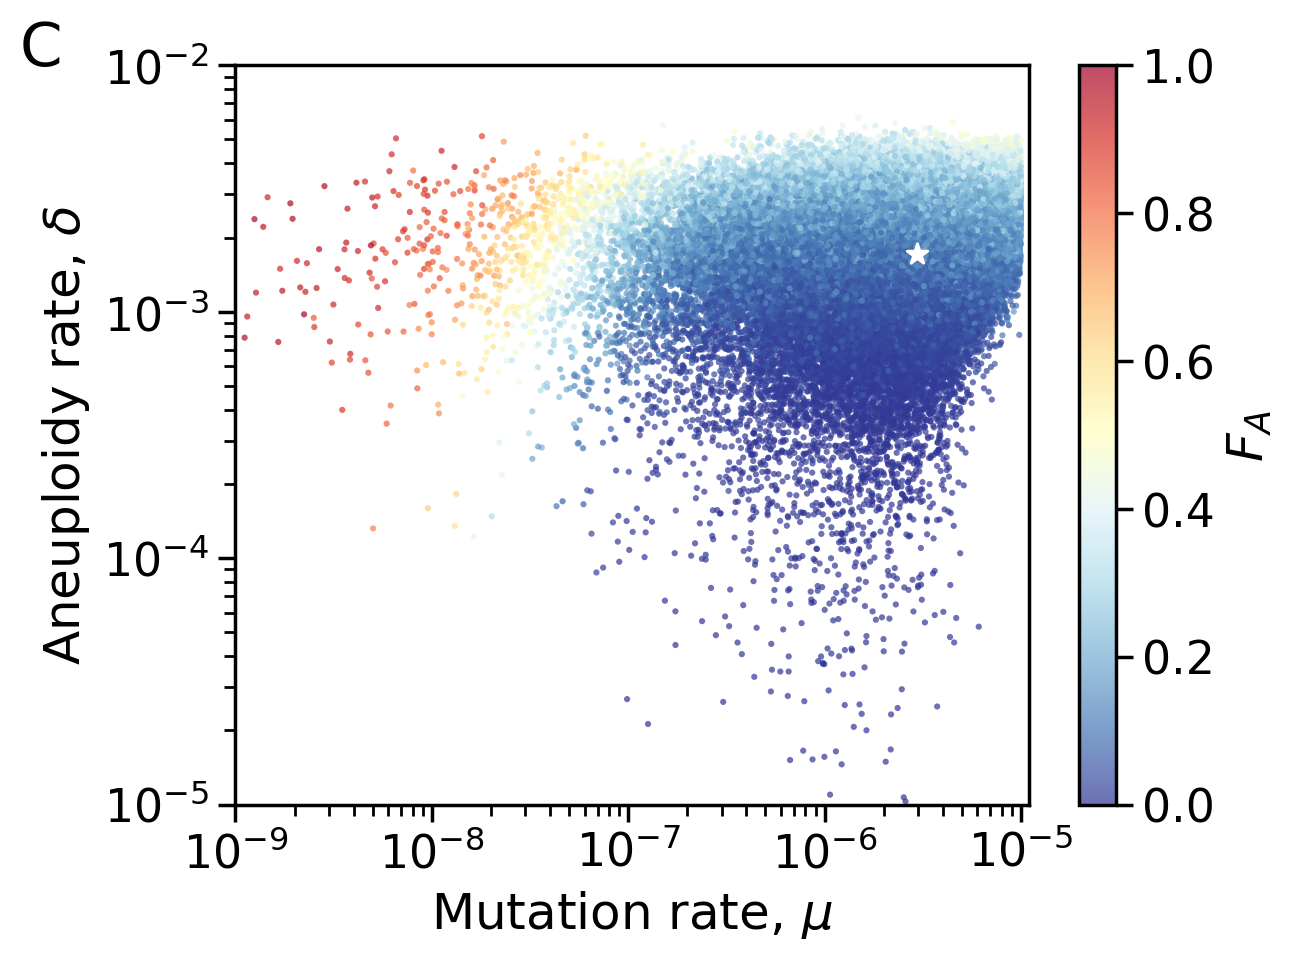

In [7]:
fig, ax = plt.subplots()

im = ax.scatter(post_sam[:,1],post_sam[:,2], c=F_A, cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(μ, δ, **star_kw)
ax.set_xscale('log')
ax.set_yscale('log')
xlabel = ax.set_xlabel('Mutation rate, $\mu$')
ax.set_ylabel('Aneuploidy rate, $\delta$')
ax.set_xlim([1e-9,1.1e-5])
ax.set_ylim([1e-5,1e-2])
panel_label = ax.text(8e-11, .01, 'C', **panel_label_kw)

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
# fig.savefig('../../figures/F_A_mu_delta.pdf', **bbox);

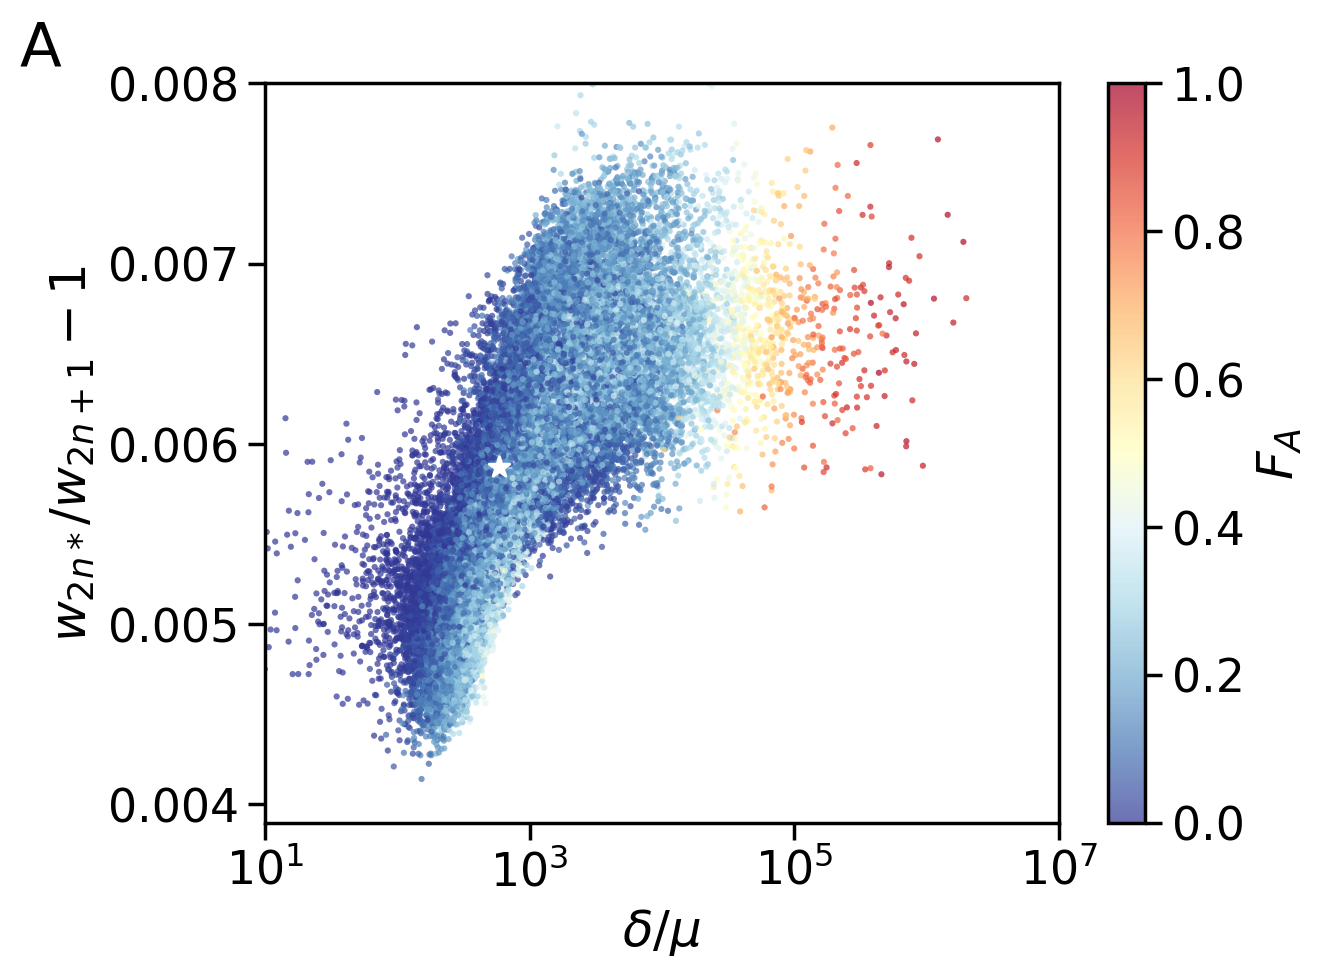

In [8]:
fig, ax = plt.subplots()

im = ax.scatter(post_sam[:,2]/post_sam[:,1],post_sam[:,5]/post_sam[:,3]-1, c=F_A, 
                cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(δ/μ, w3/w1-1, **star_kw)
ax.set_xscale('log')
xlabel = ax.set_xlabel('$\delta/\mu$')
ax.set_ylabel('$w_{2n*}/w_{2n+1}-1$')
ax.set_xlim([10,1e7])
ax.set_ylim([.0039,.008])
panel_label = panel_label = ax.text(0.14, 0.0081, 'A', **panel_label_kw)

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
fig.savefig('../../figures/F_A_delta-mu-ratio_1.pdf', **bbox)

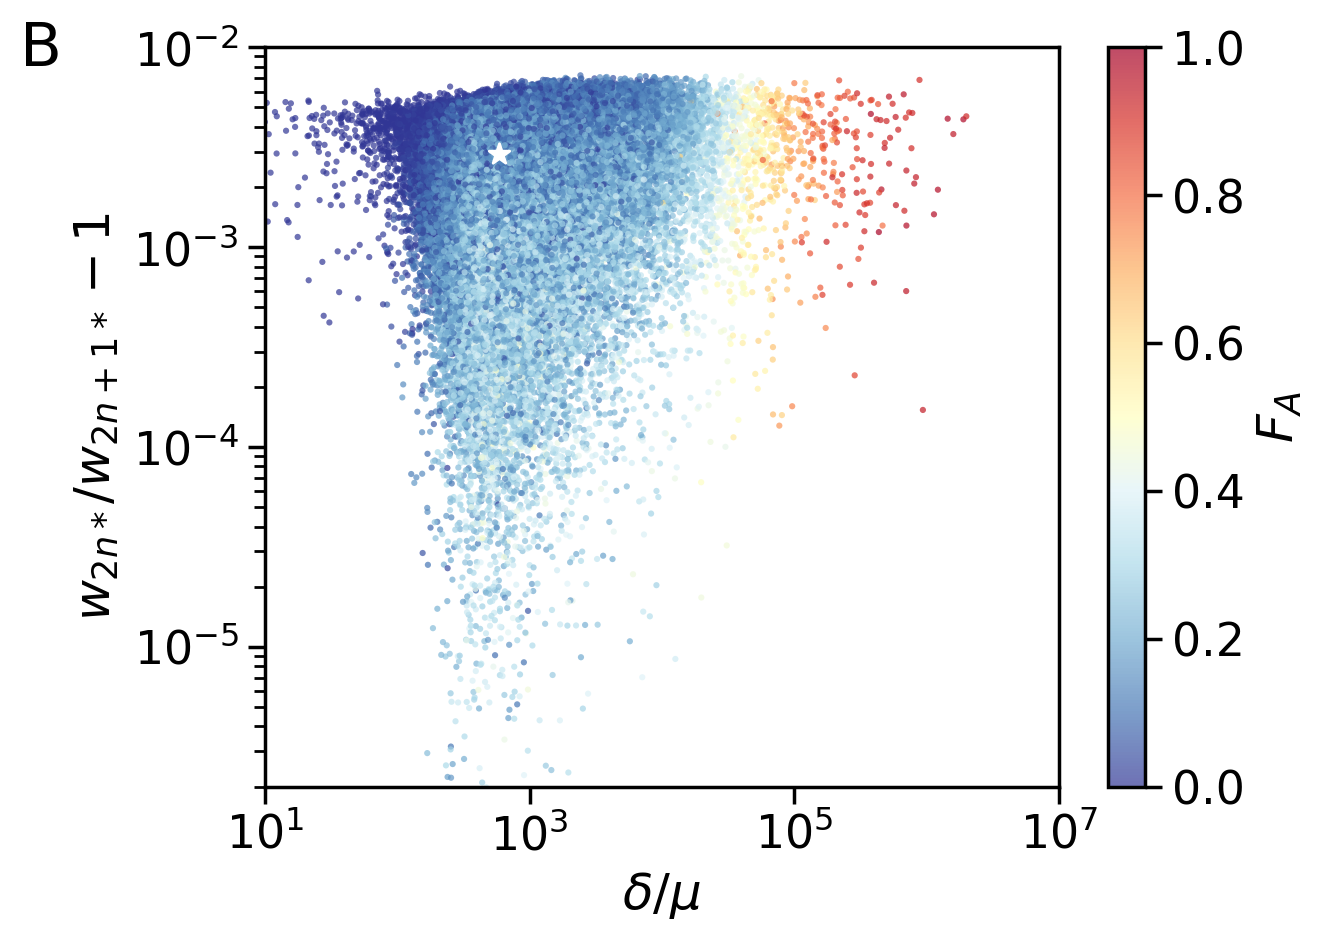

In [9]:
fig, ax = plt.subplots()

im = ax.scatter(post_sam[:,2]/post_sam[:,1],post_sam[:,5]/post_sam[:,4]-1, c=F_A, 
                cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(δ/μ, w3/w2-1, **star_kw)
ax.set_xscale('log')
ax.set_yscale('log')
xlabel = ax.set_xlabel('$\delta/\mu$')
ax.set_ylabel('$w_{2n*}/w_{2n+1*}-1$')
ax.set_xlim([10,1e7])
ax.set_ylim([2e-6,1e-2])
panel_label = panel_label = ax.text(0.14, 0.0081, 'B', **panel_label_kw)

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
fig.savefig('../../figures/F_A_delta-mu-ratio_2.pdf', **bbox)

# MAP frequency dynamics

In [62]:
M0 = np.diag(np.repeat(0.,5))
M0[0][1] = 0
M0[1][2] = μ
M0[2][3] = 0 
M0[0][4] = μ
M0 = M0.transpose() 
np.fill_diagonal(M0,0) #neutralling side effect
np.fill_diagonal(M0, 1-M0.sum(axis=0)) #side effect

M = np.diag(np.repeat(0.,5))
M[0][1] = δ
M[1][2] = μ
M[2][3] = δ 
M[0][4] = μ
M = M.transpose() 
np.fill_diagonal(M,0) #neutralling side effect
np.fill_diagonal(M, 1-M.sum(axis=0)) #side effect

w = np.array([1., w1, w2, w3, w3])
S = np.diag(w)
tmax = 2500

p0 = np.zeros((tmax, 5), dtype=float)
p0[0, 0] = 1.0

p = np.zeros((tmax, 5), dtype=float)
p[0, 0] = 1.0

In [63]:
for t in range(1, tmax):
    p0[t] = M0 @ S @ p0[t-1]
    p0[t] /= p0[t].sum()
    p[t] = M @ S @ p[t-1]
    p[t] /= p[t].sum()

F_A = 0.09792203735027313


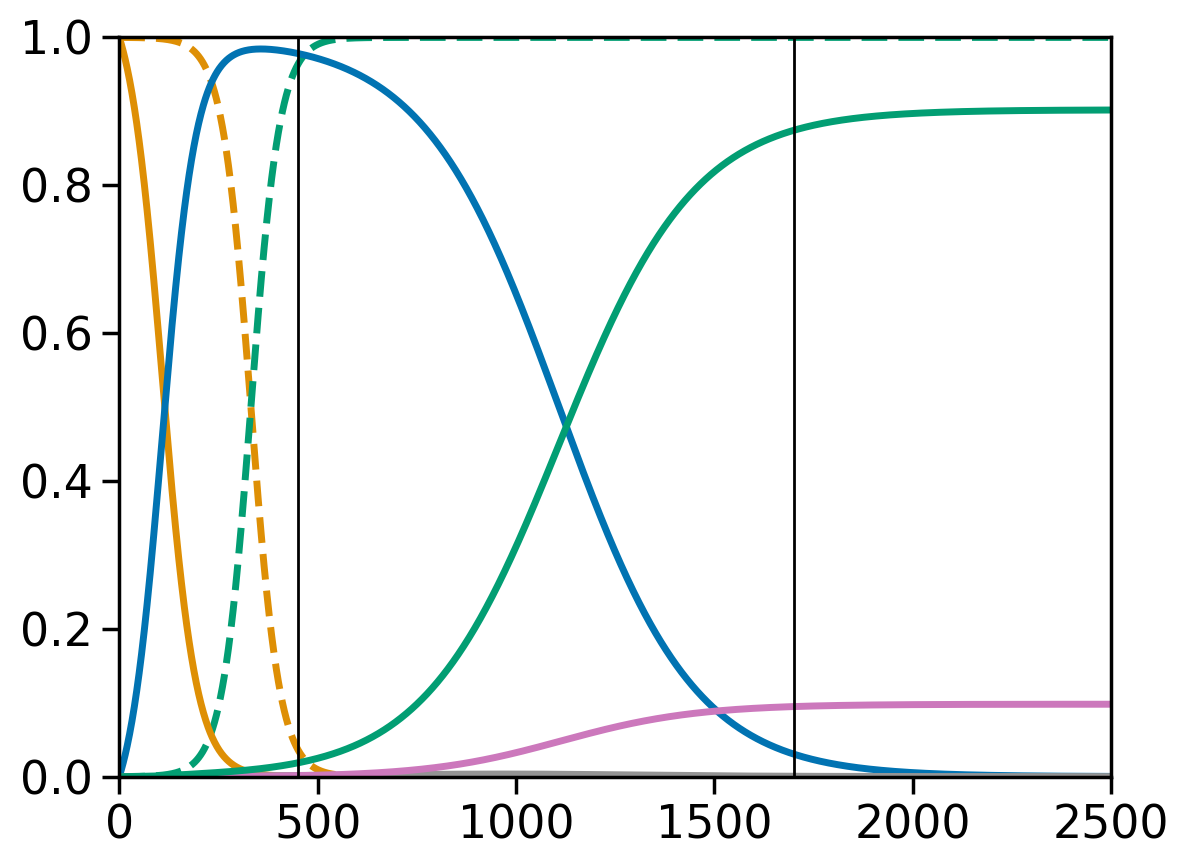

In [64]:
for pi, c in zip(p0.T, genotype_colors):
    plt.plot(range(tmax), pi, color=c, ls='--')
for pi, c in zip(p.T, genotype_colors):
    plt.plot(range(tmax), pi, color=c)   
plt.ylim(0, 1)
plt.xlim(0, tmax)
# plt.axhline(0.5, ls='--')
plt.axvline(450, color='k', lw=1);
plt.axvline(1700, color='k', lw=1);
print("F_A =", p[-1, 3])

In [29]:
def simTP(repetition=50, max_gen=5e6, seed=10, fixation=0.999):
    return modelext.run_simulations(
        N, μ, δ, δ,
        w1, w2, w3, 
        repetitions=repetition, max_gen=5e4 ,seed=seed, 
        clonal_intf=True, fixation=fixation)

In [30]:
# simMAP = simTP() #simulate the MAP

In [31]:
# np.savez_compressed('../../results/posterior_predictions/simMAP', np.array(simMAP, dtype=object), allow_pickle=True)

In [25]:
simMAP = np.load('../../results/posterior_predictions/simMAP.npz', allow_pickle=True)['arr_0']
simMAP_totalfix = np.array(simMAP[1])
totalfix_MAP = simMAP_totalfix[:,-1,:]+simMAP_totalfix[:,-2,:]
simMAP_2nstar = np.array([np.vstack((simMAP_totalfix[x],totalfix_MAP[x]))for x in range(len(totalfix_MAP))])
np.shape(simMAP_2nstar),np.shape(simMAP_totalfix)

((2398, 6, 50), (2398, 5, 50))

In [26]:
print("highest frequency of 2n+1 = {}, highest frequency of 2n+1* ={}".format(
    simMAP_totalfix[:,1,:].max(axis=0).min(), simMAP_totalfix[:,2,:].max(axis=0).max() 
))
print("mean F_A = ", simMAP_totalfix[:, 3, :].mean())

highest frequency of 2n+1 = 0.980132607003891, highest frequency of 2n+1* =0.004782256809338521
mean F_A =  0.05594566373274746


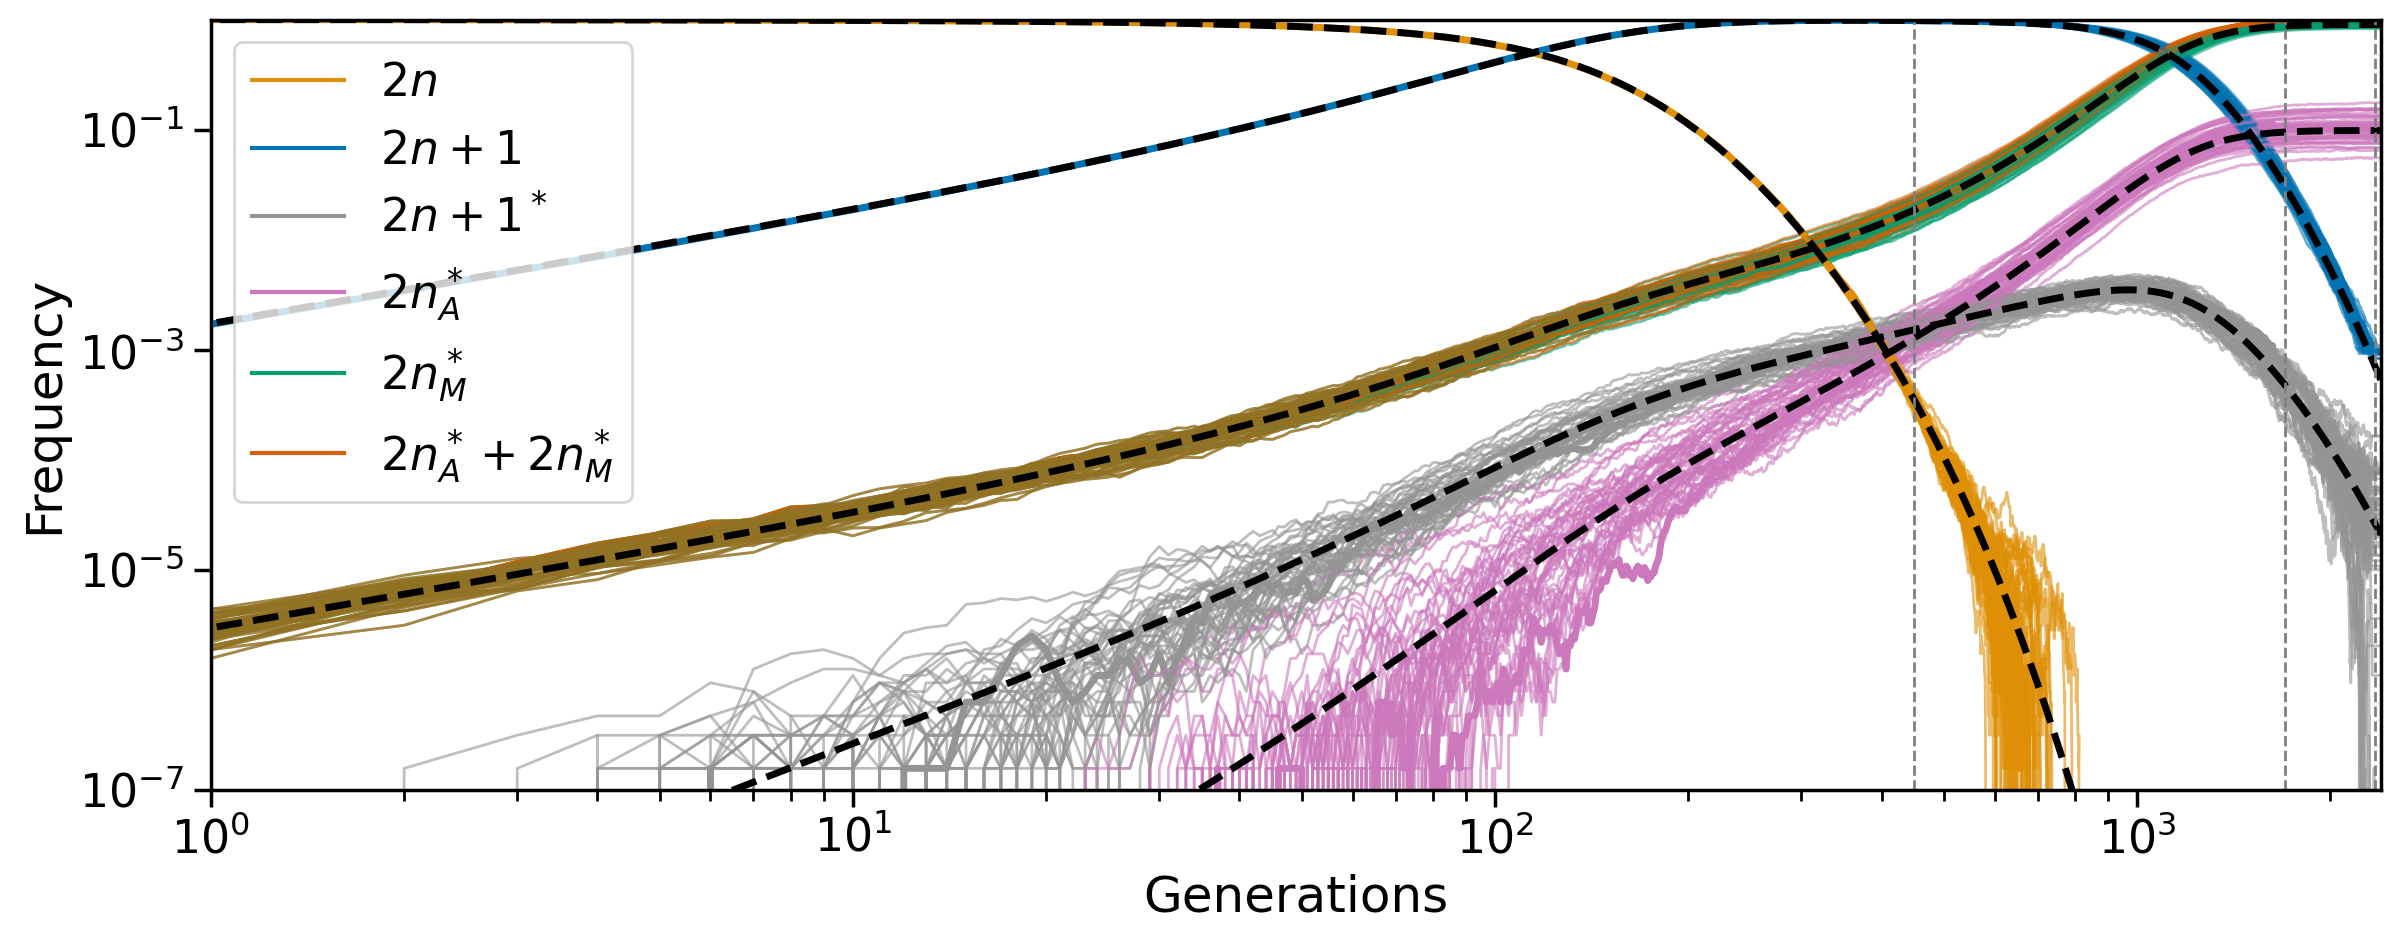

In [61]:
line_kws = dict(linestyle='--', linewidth=1, color='grey')
plot_kws = dict(fixation=0.9999, alpha=.6, xlim=(0, len(totalfix_MAP)), lw=1)

ax = modelext.plot_progress(
    simMAP_2nstar, 
    0, 
    genotype_labels, 
    genotype_colors,
    legend=True
)
for x in range(50):
    modelext.plot_progress(
        simMAP_2nstar, x, 
        genotype_labels, 
        genotype_colors,
        legend=False,
        ax=ax,
        **plot_kws
    ) 
ax.plot(range(tmax), p, 'k', ls='--');
xlabel = ax.set_xlabel("Generations")
ax.axvline(450, **line_kws)
ax.axvline(1700, **line_kws)
ax.axvline(2350, **line_kws)
ax.set_xticks([450, 1700, 2350])
# panel_label = ax.text(-.07, 1.05, 'A', transform=ax.transAxes, **panel_label_kw)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-7, 1)
ax.set_xlim(1, None);

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel])#, panel_label])
ax.figure.savefig('../../figures/MAP_freq_dynamics.pdf', **bbox);

# $F_A$ vs $N$

In [28]:
Nv = np.logspace(4, 8, 75, dtype=int)

In [47]:
# MAPsim_N = np.array([
#     modelext.run_simulations_time(
#         N, μ, δ, δ, w1, w2, w3, 
#         repetitions=250, max_gen=5e6, seed=10, 
#         fixation=0.999, clonal_intf=True,  fix_frequ=True) 
#     for N in Nv
# ], dtype=object)

In [48]:
# np.save('../../results/posterior_predictions/MAPsim_N',  MAPsim_N,  allow_pickle=True)

In [49]:
MAPsim_N = np.load('../../results/posterior_predictions/MAPsim_N.npy', allow_pickle=True)

In [50]:
# F_A
mean_MAP_N = np.array([np.mean(MAPsim_N[x,2][0][0]) for x in range(len(MAPsim_N))]) # 

(0.0, 1.0)

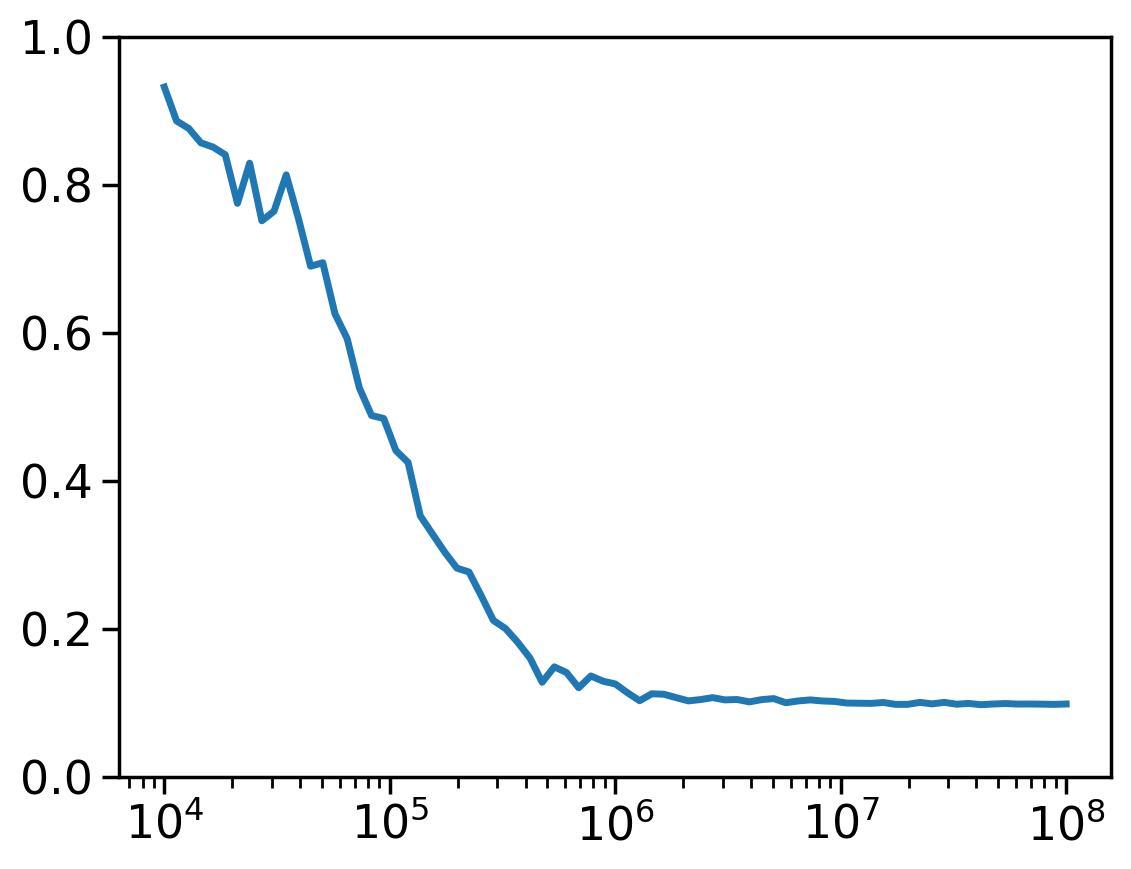

In [54]:
plt.plot(Nv, mean_MAP_N)
plt.xscale('log')
plt.ylim(0, 1)

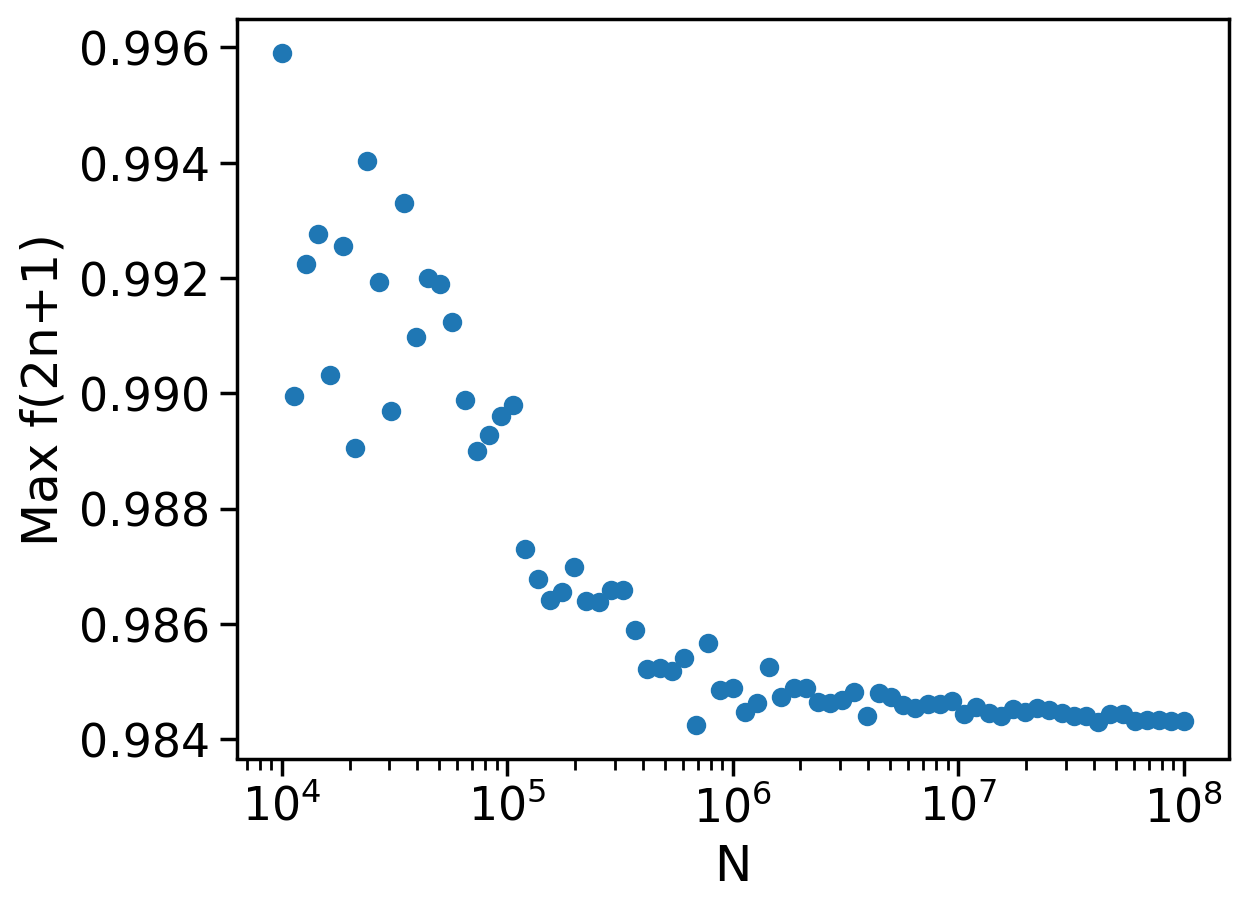

In [55]:
# max aneuploidy
max_MAP_N = np.array([np.mean(MAPsim_N[x,3]) for x in range(len(MAPsim_N))])
plt.plot(Nv, max_MAP_N, 'o')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Max f(2n+1)');

In [56]:
n = 10000
bs = np.array([
    [
        np.random.choice(MAPsim_N[x,2][0][0], MAPsim_N[x,2][0][0].size) 
        for i in range(n)
    ] 
    for x in range(len(MAPsim_N)) 
])
bs.shape

(75, 10000, 250)

In [57]:
bs_mean = np.mean(bs, axis=2)
bs_mean.shape

(75, 10000)

In [58]:
perc_MAP_N = np.percentile(bs_mean, (2.5, 97.5), axis=1)
perc_MAP_N.shape

(2, 75)

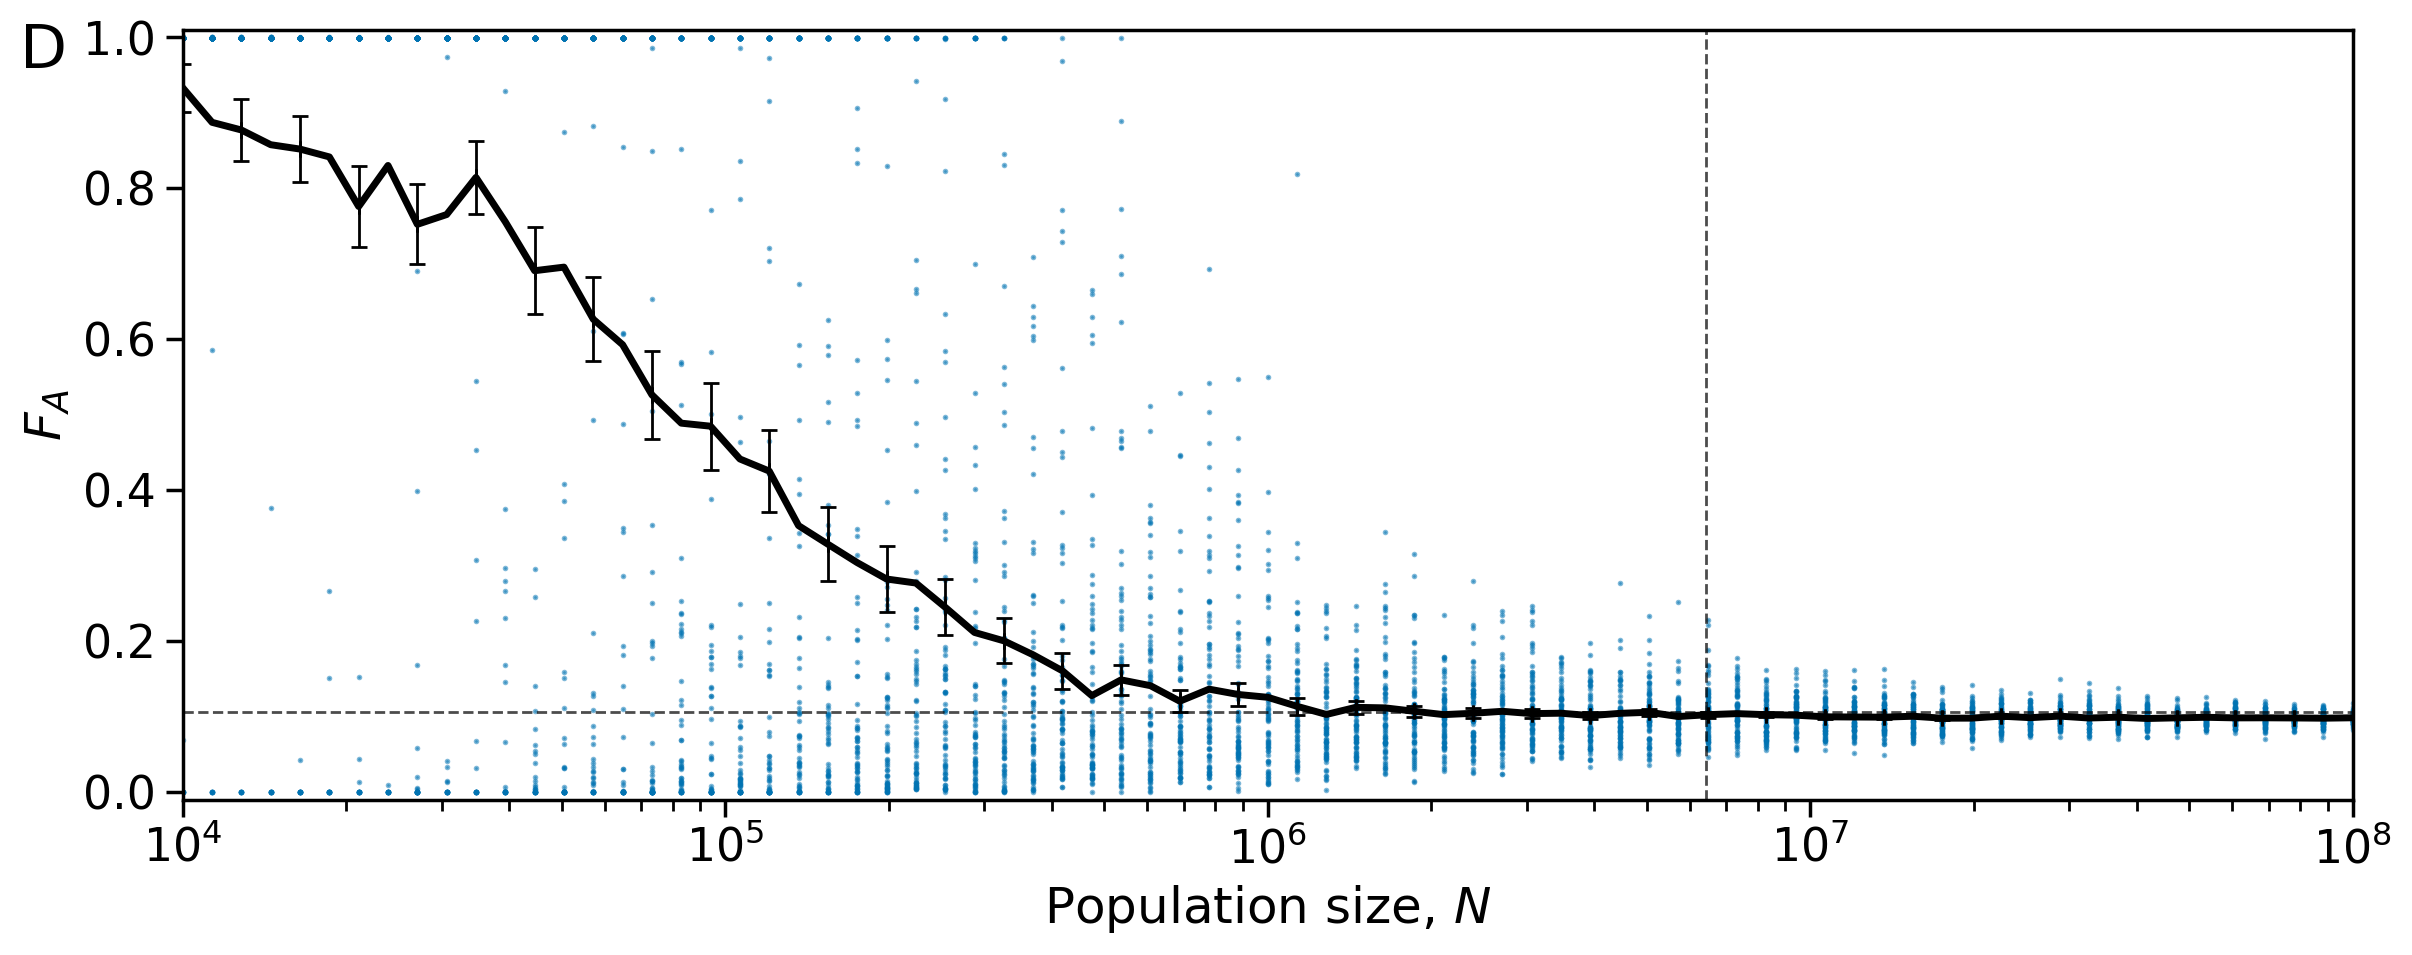

In [59]:
line_kws = dict(color='k', ls='--', lw=1, alpha=0.7)

fig, ax = plt.subplots(figsize=(14,5))

X = np.array([MAPsim_N[x,2][0][0] for x in range(len(MAPsim_N))])
for i in range(X.shape[0]):
    ax.scatter(Nv, X[:,i], color=blue, s=1, alpha=0.5)
    
# F_A
ax.errorbar(
    Nv, 
    mean_MAP_N, 
    mean_MAP_N - perc_MAP_N[0],
    perc_MAP_N[1] - mean_MAP_N,
    fmt='k', capsize=3, elinewidth=1, errorevery=2)

# Max aneuploidy
# ax.plot(Nv, max_MAP_N)

# 
ax.axvline(6.425e6, **line_kws)
ax.axhline(0.106, **line_kws)

ax.set_xscale('log')
xlabel = ax.set_xlabel('Population size, $N$')
ax.set_xlim(Nv.min(), Nv.max())
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel("$F_A$")
panel_label = ax.text(-0.075, 0.95, 'D', transform=ax.transAxes, **panel_label_kw)
bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
# fig.savefig('../../figures/FA_vs_N.pdf', **bbox)

# All together

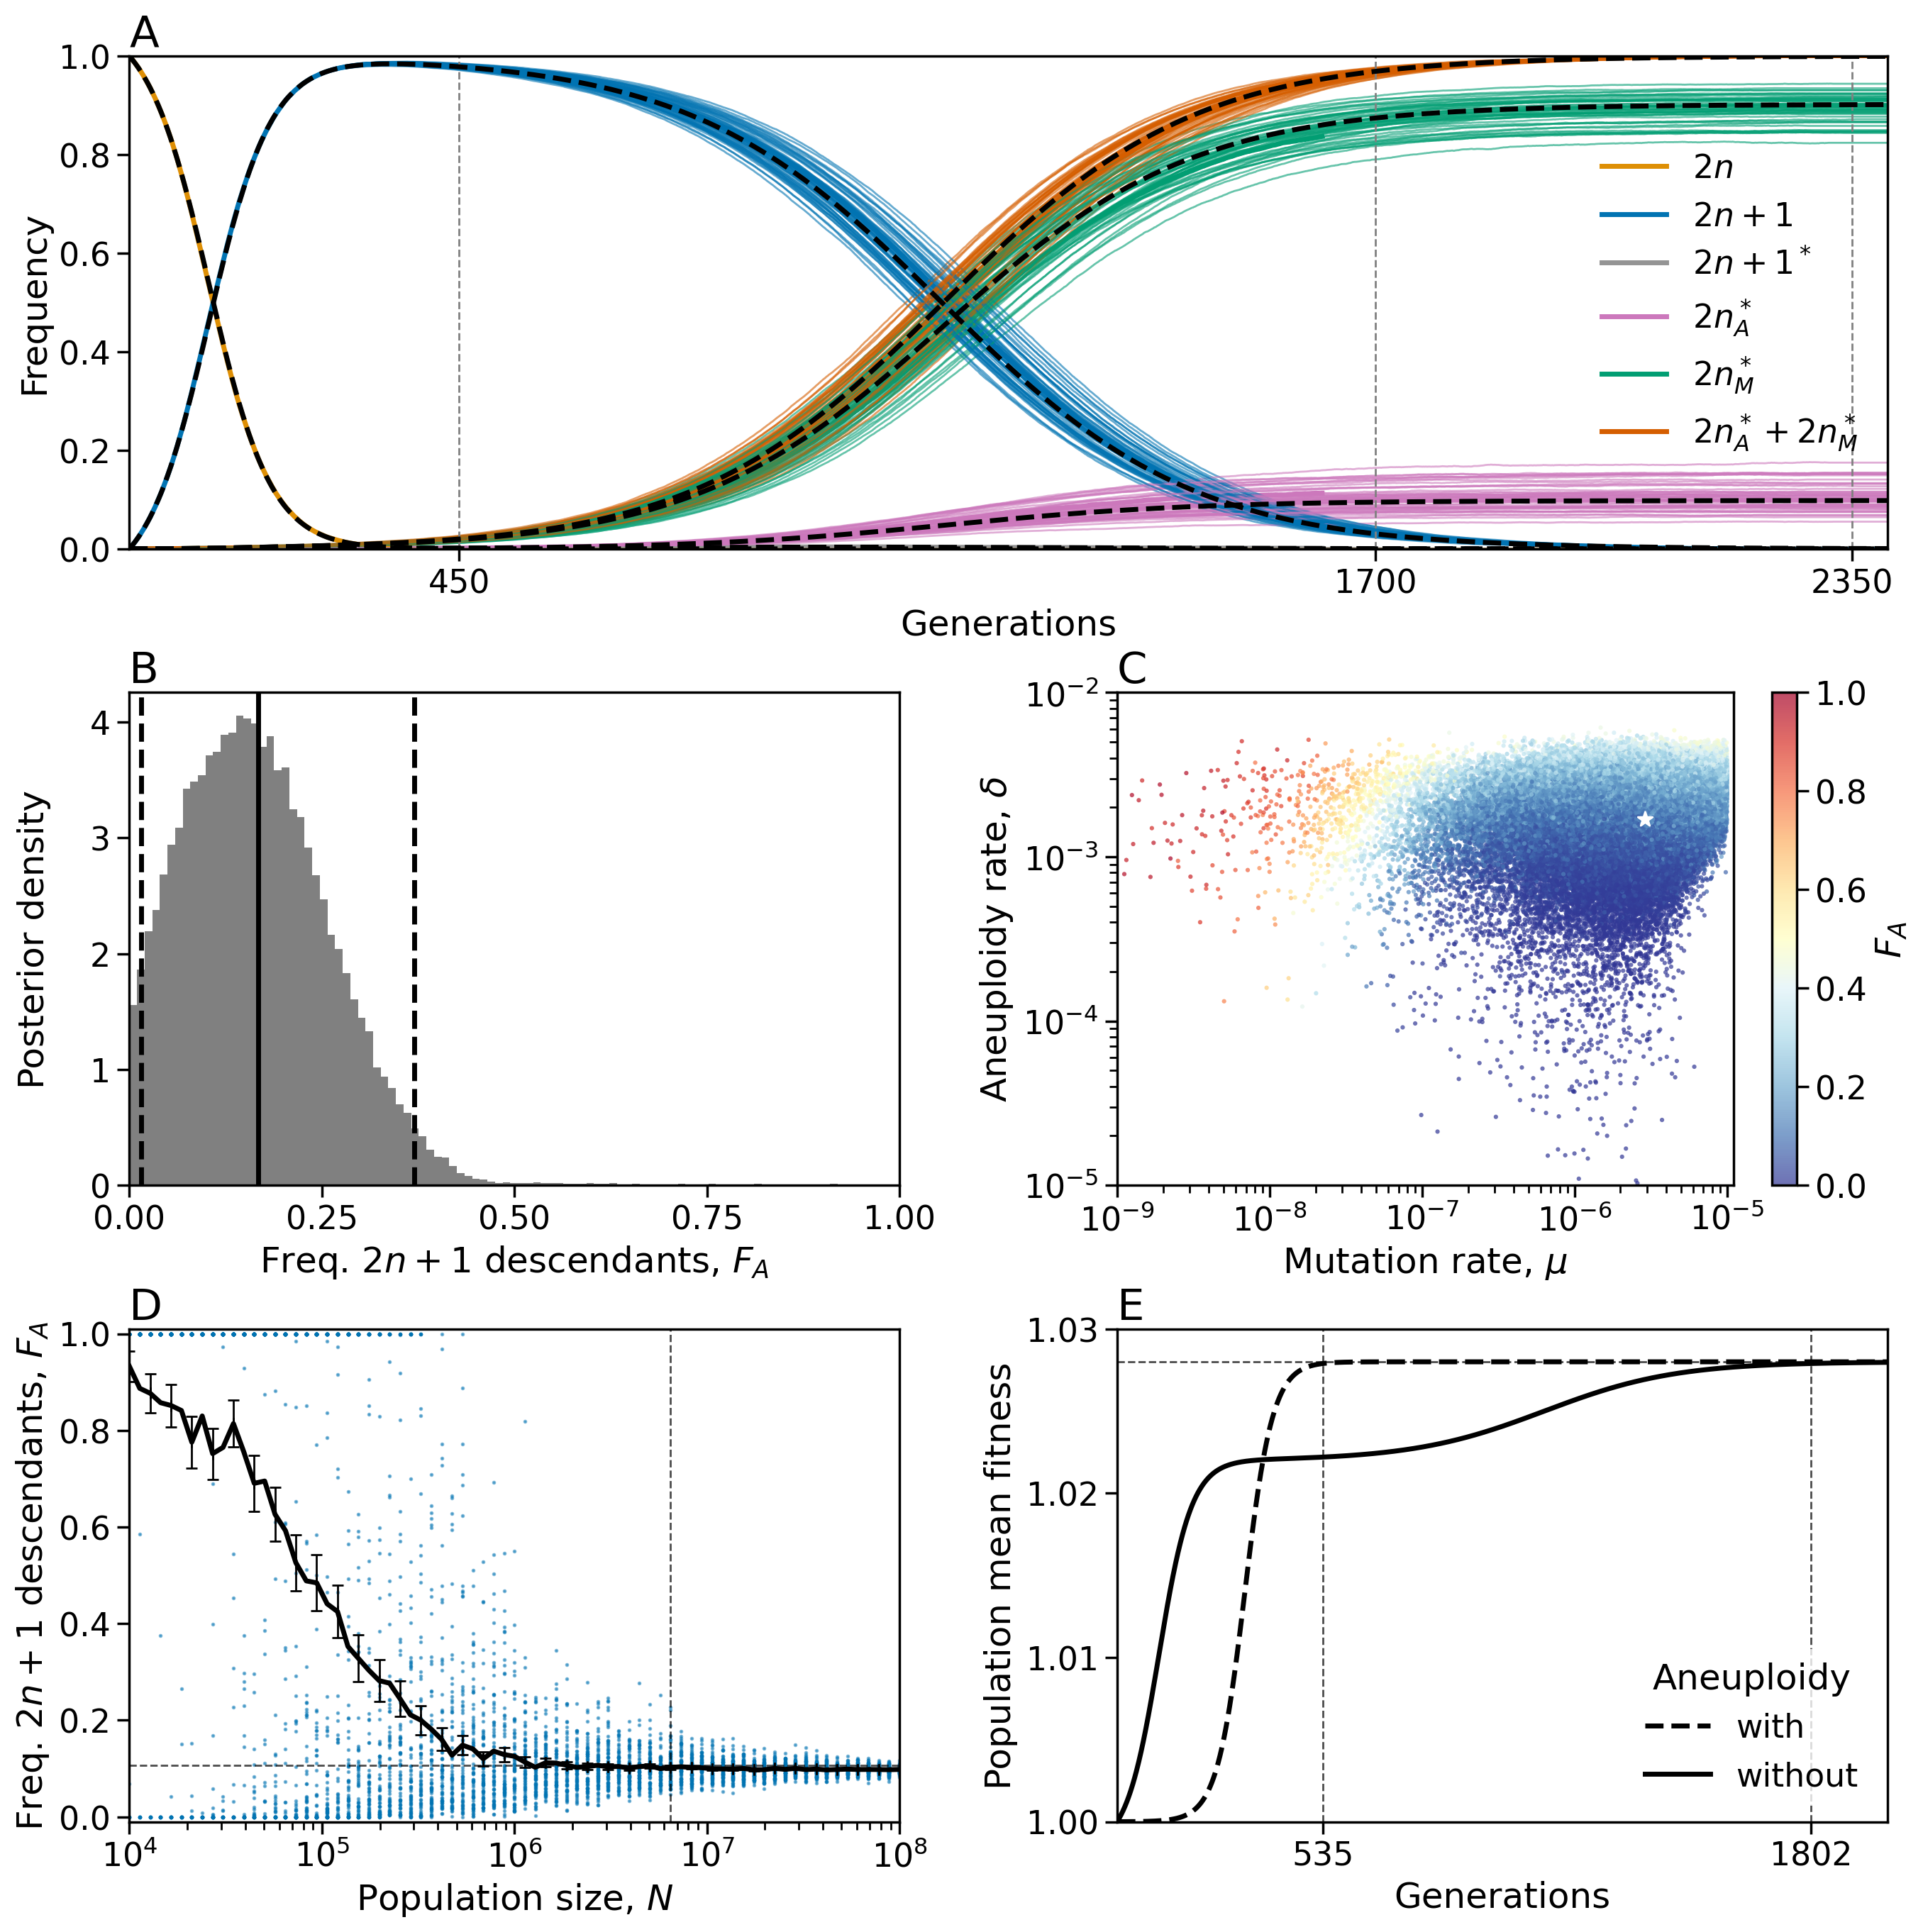

In [93]:
fig, axes = plt.subplot_mosaic((['A', 'A'], ['B', 'C'], ['D', 'E']), figsize=(14, 14))
FA_label = r'Freq. $2n+1$ descendants, $F_A$'

## A
ax = axes['A']
line_kws = dict(linestyle='--', linewidth=1, color='grey')
plot_kws = dict(fixation=0.9999, alpha=.6, xlim=(0, len(totalfix_MAP)), lw=1)

modelext.plot_progress(
    simMAP_2nstar, 
    0, 
    genotype_labels, 
    genotype_colors,
    legend=True,
    ax=ax
)
for x in range(50):
    modelext.plot_progress(
        simMAP_2nstar, x, 
        genotype_labels, 
        genotype_colors,
        legend=False,
        ax=ax,
        **plot_kws
    ) 
ax.set_xlabel("Generations")
ax.axvline(450, **line_kws)
ax.axvline(1700, **line_kws)
ax.axvline(2350, **line_kws)
ax.set_xticks([450, 1700, 2350])
ax.legend(loc='center right', frameon=False)

## deterministic model
for pi, c in zip(p.T, genotype_colors):
    ax.plot(range(tmax), pi, color='k', ls='--')
ax.plot(range(tmax), p[:, 3] + p[:, 4], color='k', ls='--') # 2n* sum   

## B 
ax = axes['B']
ax.hist(F_A, 100, density=True,color='grey')
ax.axvline(x=mean_FA,color='k')
ax.axvline(x=perc_FA[0],color='k',ls='--')
ax.axvline(x=perc_FA[1],color='k',ls='--')
ax.set_xlim([0,1])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xlabel(FA_label)
ax.set_ylabel('Posterior density')

## C 
ax = axes['C']
im = ax.scatter(post_sam[:,1],post_sam[:,2], c=F_A, cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(2.9e-6,1.7e-3, **star_kw)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mutation rate, $\mu$')
ax.set_ylabel('Aneuploidy rate, $\delta$')
ax.set_xlim([1e-9,1.1e-5])
ax.set_ylim([1e-5,1e-2])

## D 
ax = axes['D']
line_kws = dict(color='k', ls='--', lw=1, alpha=0.7)

X = np.array([MAPsim_N[x,2][0][0] for x in range(len(MAPsim_N))])
for i in range(X.shape[0]):
    ax.scatter(Nv, X[:,i], color=blue, s=1, alpha=0.5)

ax.errorbar(
    Nv, 
    mean_MAP_N, 
    mean_MAP_N - perc_MAP_N[0],
    perc_MAP_N[1] - mean_MAP_N,
    fmt='k', capsize=3, elinewidth=1, errorevery=2)
ax.axvline(6.425e6, **line_kws)
ax.axhline(0.106, **line_kws)

ax.set_xscale('log')
ax.set_xlabel('Population size, $N$')
ax.set_xlim(Nv.min(), Nv.max())
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel(FA_label)

for k, ax in axes.items():
    ax.text(0, 1.02, k, transform=ax.transAxes, **panel_label_kw)

## E 
## deterministic model
ax = axes['E']
# delta = 0
W0 = p0@w
ax.plot(range(tmax), W0, '--', color='k')
# delta > 0
W = p@w
ax.plot(range(tmax), W, '-', color='k')

ax.set_xlabel("Generations")
ax.set_ylabel("Population mean fitness")
fix = (W > w3*0.9999).argmax()# 500 # ((p[:, 3] + p[:, 4]) > 0.99).argmax() # 499
fix0 =  (W0 > w3*0.9999).argmax()# 1900 # ((p0[:, 3] + p0[:, 4]) > 0.99).argmax() # 1898
ax.axvline(fix, **line_kws)
ax.axvline(fix0, **line_kws)
ax.axhline(w3, **line_kws)
ax.set(ylim=(1, None), xlim=(0, 2000))
ax.set_xticks([fix, fix0])
ax.set_yticks([1, 1.01, 1.02, 1.03])
ax.legend(["with", "without"], title='Aneuploidy', loc='lower right', edgecolor='none')

## Figure

fig.align_ylabels([axes['A'], axes['B'], axes['D']])
fig.tight_layout(h_pad=0)
fig.savefig('../../figures/FA.pdf')